# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [33]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [6]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv("megaline_calls.csv")
internet = pd.read_csv("megaline_internet.csv")
messages = pd.read_csv("megaline_messages.csv")
plans = pd.read_csv("megaline_plans.csv")
users = pd.read_csv("megaline_users.csv")

## Preparar los datos

## 1.4 Tarifas

In [6]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
calls.info()
print()
internet.info()
print()
messages.info()
print()
plans.info()
print()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  D

In [7]:
# Imprime una muestra de los datos para las tarifas
print(calls.head())
print()
print(internet.head())
print()
print(messages.head())
print()
print(plans.head())
print()
print(users.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0    

* Calls: Para este DF consta de 4 columnas, en donde el id y call_date son tipo object, se necesitan cambiar, en especial las fechas para poder trabajar de mejor manera con estos datos. Aparentemente no cuenta con valores ausentes. Para cambiar la fecha es de la siguiente manera: calls['call_date'] = pd.to_datetime(calls['call_date']). Cueta con valores duplicados, pero no es tan necesario el eliminarlos. El iD no cambia porque son identificadores únicos y mantenerlos como string esta bien.
* Internet: De igual manera fechas y user_id son de tipo object, se necesitan cambiar, y lo haremos de la siguiente manera: internet['session_date'] = pd.to_datetime(internet['session_date']). Aparentemente no cuenta con valores nulos, son 4 columnas con valores duplicados, pero no necesariamente tenemos que eliminarlos.
* Messages: Tenemos 3 columnas, el id y fecha sigue siendo object, por lo tanto, debemos cambiar el tipo de dato de la misma forma que la anterior: messages['message_date'] = pd.to_datetime(messages['message_date']). Cuenta con las mismas características de valores duplicados, sin tenerlos que modificar, no cuenta con valores ausentes.
* Plans: Tenemos 8 columnas, de las cuales 2 son tipo float, esto no es un problema, ya que si se usa números decimales, hay 1 column ipo object, pero que solo nos da el nombre del plan, es una tabla corta, ya que solo viene la información de los planes, por lo tanto no incluye duplicados ni tampoco valores ausentes. Nota: solo son dos filas ya que solo son dos planes.
* Users: En este DF debemos identificar que en user_id no haya valores duplicados ni ausentes, ya que podría haber un error a la hora de trabajar con ellos y reemplazarlos. Después un punto importante es que en la columna churn_date contamos con la mayoría valores ausentes, solo hay 34 valores no nulos. En la columna reg_date, debemos de cambiar el tipo de dato, ya que esta en object y debemos cambiarlo para poder trabajar con el. Por lo tanto se cambiaría de la siguiente manera users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce'). No estoy seguro si trabajaremos con la fecha de registro, pero también la podriamos cambiar. en consideración a todo lo demás parece estar en orden. Para verificar si hay usuarios duplicaods podría analizarlos de la siguiente manera: print(f"¿Hay user_id duplicados? {users['user_id'].duplicated().any()}") print(f"Total usuarios únicos: {users['user_id'].nunique()}"). Como observación 466 usuarios siguen activos y 34 cancelaron su plan. Todos los datos estan en MegaBytes.


## 1.5. Corregir datos

In [7]:
# Corrección de fechas para cada df
# Convertir fechas en calls
calls['call_date'] = pd.to_datetime(calls['call_date'])
# Convertir fechas en internet  
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Convertir fechas en messages
messages['message_date'] = pd.to_datetime(messages['message_date'])

# Para users (con manejo de errores para valores ausentes)
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

# Verificar duplicados en users 
print(f"¿Hay user_id duplicados? {users['user_id'].duplicated().any()}")
print(f"Total usuarios únicos: {users['user_id'].nunique()}")

¿Hay user_id duplicados? False
Total usuarios únicos: 500


## Enriquecer los datos

In [8]:
# Convertir MB a GB para facilitar cálculos de exceder límites por paquete
internet['gb_used'] = internet['mb_used'] / 1024

# Extraer el uso temporal para asignarle un número a cada mes y día 
# Para análisis temporal
calls['year'] = calls['call_date'].dt.year
calls['month'] = calls['call_date'].dt.month
calls['day_of_week'] = calls['call_date'].dt.dayofweek
# Identificar los fines de semana 
calls['is_weekend'] = calls['call_date'].dt.dayofweek >= 5

# Lo mismo para internet y messages
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

# Calcular días como cliente activo
users['days_as_customer'] = (pd.Timestamp('2018-12-31') - users['reg_date']).dt.days

## 1.7. Usuarios/as

In [9]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           500 non-null    int64         
 1   first_name        500 non-null    object        
 2   last_name         500 non-null    object        
 3   age               500 non-null    int64         
 4   city              500 non-null    object        
 5   reg_date          500 non-null    datetime64[ns]
 6   plan              500 non-null    object        
 7   churn_date        34 non-null     datetime64[ns]
 8   days_as_customer  500 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


In [10]:
# Imprime una muestra de datos para usuarios
print(users)


     user_id first_name   last_name  age  \
0       1000   Anamaria       Bauer   45   
1       1001     Mickey   Wilkerson   28   
2       1002     Carlee     Hoffman   36   
3       1003   Reynaldo     Jenkins   52   
4       1004    Leonila    Thompson   40   
..       ...        ...         ...  ...   
495     1495      Fidel      Sharpe   67   
496     1496      Ariel    Shepherd   49   
497     1497      Donte     Barrera   49   
498     1498       Scot  Williamson   51   
499     1499      Shena     Dickson   37   

                                          city   reg_date      plan  \
0        Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24  ultimate   
1              Seattle-Tacoma-Bellevue, WA MSA 2018-08-13      surf   
2         Las Vegas-Henderson-Paradise, NV MSA 2018-10-21      surf   
3                                Tulsa, OK MSA 2018-01-28      surf   
4              Seattle-Tacoma-Bellevue, WA MSA 2018-05-23      surf   
..                                         ..

Por lo que observamos los datos son los adecuados en cada columna, el tipo de dato ya lo corregimos y es adecuado para trabajar con cada uno según su clase. Creamos la columna days_as_costumer con la finalidad de contar los días en los que han sido clientes. Por lo tanto, ya terminamos de ajustar los datos en este df. Los valores ausentes estoy en duda si eliminarlos o dejarlos, ya que es información importante, ya que nos representan usuarios activos.

### 1.7.1. Corregir los datos

In [11]:
# Celda 25 - Verificar que las correcciones se aplicaron correctamente
print("Verificación de tipos de datos después de correcciones:")
print(users.dtypes)
print(f"\nValores ausentes en churn_date: {users['churn_date'].isnull().sum()}")

Verificación de tipos de datos después de correcciones:
user_id                      int64
first_name                  object
last_name                   object
age                          int64
city                        object
reg_date            datetime64[ns]
plan                        object
churn_date          datetime64[ns]
days_as_customer             int64
dtype: object

Valores ausentes en churn_date: 466


## 1.8. Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           137735 non-null  object        
 1   user_id      137735 non-null  int64         
 2   call_date    137735 non-null  datetime64[ns]
 3   duration     137735 non-null  float64       
 4   year         137735 non-null  int32         
 5   month        137735 non-null  int32         
 6   day_of_week  137735 non-null  int32         
 7   is_weekend   137735 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(3), int64(1), object(1)
memory usage: 5.9+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
print(calls)

              id  user_id  call_date  duration  year  month  day_of_week  \
0        1000_93     1000 2018-12-27      8.52  2018     12            3   
1       1000_145     1000 2018-12-27     13.66  2018     12            3   
2       1000_247     1000 2018-12-27     14.48  2018     12            3   
3       1000_309     1000 2018-12-28      5.76  2018     12            4   
4       1000_380     1000 2018-12-30      4.22  2018     12            6   
...          ...      ...        ...       ...   ...    ...          ...   
137730  1499_199     1499 2018-11-21      8.72  2018     11            2   
137731  1499_200     1499 2018-10-20     10.89  2018     10            5   
137732  1499_201     1499 2018-09-21      8.12  2018      9            4   
137733  1499_202     1499 2018-10-10      0.37  2018     10            2   
137734  1499_203     1499 2018-12-29     13.86  2018     12            5   

        is_weekend  
0            False  
1            False  
2            False  
3  

De información general observamos el id de la llamada, que es igual que el user_id pero con una terminación numérica, el cual es de tipo object. si en un futuro nos pide el hacer el conteo lo tendremos que modificar. Para el call_date ya se hizo el cambio de object a datetime. Se añadió si la llamada había caido en fin de semana. Así como la misma separación de los valores de día, año y mes. Podríamos analizar cuales fueron las llamadas con 0 minutos. también el rango de fechas de las llamadas e incluso si hay algún error de datos que podrían ser negativos. Esto lo añadiré en el apartado de enriquecer los datos.

### 1.8.1. Enriquecer los datos

In [14]:
# Verificar si hay valores negativos en duración
print(f"¿Hay duraciones negativas? {(calls['duration'] < 0).any()}")

# Verificar rango de fechas
print(f"Rango de fechas: {calls['call_date'].min()} a {calls['call_date'].max()}")

# Verificar si hay llamadas de duración 0
print(f"Llamadas de 0 minutos: {(calls['duration'] == 0).sum()}")

¿Hay duraciones negativas? False
Rango de fechas: 2018-01-15 00:00:00 a 2018-12-31 00:00:00
Llamadas de 0 minutos: 26834


## 1.9. Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 2.0+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
print(messages)

             id  user_id message_date  month
0      1000_125     1000   2018-12-27     12
1      1000_160     1000   2018-12-31     12
2      1000_223     1000   2018-12-31     12
3      1000_251     1000   2018-12-27     12
4      1000_255     1000   2018-12-26     12
...         ...      ...          ...    ...
76046  1497_526     1497   2018-12-24     12
76047  1497_536     1497   2018-12-24     12
76048  1497_547     1497   2018-12-31     12
76049  1497_558     1497   2018-12-24     12
76050  1497_613     1497   2018-12-23     12

[76051 rows x 4 columns]


En este df solamente teníamos 3 columnas, la cuarta se añadió con la finalidad de contar el mes de la fecha añadida en message_date. Por lo tanto, es más fácil contar el mes en el que fueron enviados los mensajes. No se le tiene que cambiar ya algún tipo de dato, ya que tenemos lo que necesitamos, pues con anterioridad cambiamos las fechas a datetime. No hay valores ausentes y los datos están listos para el análisis mensual.

### 1.9.1. Enriquecer los datos

In [17]:
# Verificaciones adicionales 
print(f"Rango de fechas: {messages['message_date'].min()} a {messages['message_date'].max()}")
print(f"¿Hay valores ausentes? {messages.isnull().sum().sum()}")
print(f"Total de mensajes: {len(messages)}")

Rango de fechas: 2018-01-15 00:00:00 a 2018-12-31 00:00:00
¿Hay valores ausentes? 0
Total de mensajes: 76051


## 1.10. Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
 5   month         104825 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 4.4+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
print(internet)

              id  user_id session_date  mb_used   gb_used  month
0        1000_13     1000   2018-12-29    89.86  0.087754     12
1       1000_204     1000   2018-12-31     0.00  0.000000     12
2       1000_379     1000   2018-12-28   660.40  0.644922     12
3       1000_413     1000   2018-12-26   270.99  0.264639     12
4       1000_442     1000   2018-12-27   880.22  0.859590     12
...          ...      ...          ...      ...       ...    ...
104820  1499_215     1499   2018-10-20   218.06  0.212949     10
104821  1499_216     1499   2018-12-30   304.72  0.297578     12
104822  1499_217     1499   2018-09-22   292.75  0.285889      9
104823  1499_218     1499   2018-12-07     0.00  0.000000     12
104824  1499_219     1499   2018-12-24   758.31  0.740537     12

[104825 rows x 6 columns]


Originalmente en este df había 4 columnas, de las cuales nos indicaban el internet usado por los usuarios según el día. Lo importante era determinar el mes de uso del internet y no se le tiene que cambiar ya algún tipo de dato, ya que tenemos lo que necesitamos, pues con anterioridad cambiamos las fechas a datetime. No hay valores ausentes y los datos están listos para el análisis mensual. se añadieron las columnas para hacer uso del mes del uso del internet y los GB usados. Los mb los cambiamos a GB, esto con la finalidad de si en un futuro nos piden el análisis de excedente de datos ya tenerlo a la mano.

### 1.10.1. Enriquecer los datos

In [20]:
# Verificar rango de fechas y valores extremos
print(f"Rango de fechas: {internet['session_date'].min()} a {internet['session_date'].max()}")
print(f"Uso máximo de GB en una sesión: {internet['gb_used'].max():.2f} GB")
print(f"Sesiones con 0 MB: {(internet['mb_used'] == 0).sum()}")

Rango de fechas: 2018-01-15 00:00:00 a 2018-12-31 00:00:00
Uso máximo de GB en una sesión: 1.65 GB
Sesiones con 0 MB: 13747


## 1.11. Estudiar las condiciones de las tarifas

In [21]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(plans)


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


## 1.12. Agregar datos por usuario

In [22]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls['duration'] = np.ceil(calls['duration'])
no_minutes_id = calls.groupby(['user_id', 'month'])['duration'].sum()
print(no_minutes_id)
no_calls_id = calls.groupby(['user_id', 'month']).size()
print(no_calls_id)


user_id  month
1000     12       124.0
1001     8        182.0
         9        315.0
         10       393.0
         11       426.0
                  ...  
1498     12       339.0
1499     9        346.0
         10       385.0
         11       308.0
         12       496.0
Name: duration, Length: 2258, dtype: float64
user_id  month
1000     12       16
1001     8        27
         9        49
         10       65
         11       64
                  ..
1498     12       39
1499     9        41
         10       53
         11       45
         12       65
Length: 2258, dtype: int64


In [23]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
no_minutes_id = calls.groupby(["user_id", "month"])["duration"].sum()
print(no_minutes_id.head(15))

user_id  month
1000     12        124.0
1001     8         182.0
         9         315.0
         10        393.0
         11        426.0
         12        412.0
1002     10         59.0
         11        386.0
         12        384.0
1003     12       1104.0
1004     5         193.0
         6         275.0
         7         381.0
         8         354.0
         9         301.0
Name: duration, dtype: float64


In [24]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
no_messages_id = messages.groupby(["user_id", "month"])["id"].count()
print(no_messages_id)

user_id  month
1000     12       11
1001     8        30
         9        44
         10       53
         11       36
                  ..
1496     9        21
         10       18
         11       13
         12       11
1497     12       50
Name: id, Length: 1806, dtype: int64


In [25]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
no_internet_id = internet.groupby(["user_id", "month"])["mb_used"].sum()
print(no_internet_id)

user_id  month
1000     12        1901.47
1001     8         6919.15
         9        13314.82
         10       22330.49
         11       18504.30
                    ...   
1498     12       23137.69
1499     9        12984.76
         10       19492.43
         11       16813.83
         12       22059.21
Name: mb_used, Length: 2277, dtype: float64


In [26]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
# Convertimos primero de Series a DataFrame
no_calls_df = no_calls_id.reset_index(name = "num_calls")
no_minutes_df = no_minutes_id.reset_index(name = "total_minutes")
no_messages_df = no_messages_id.reset_index(name = "total_messages")
no_internet_df = no_internet_id.reset_index(name= "total_internet")

#Fusionamos mediante merge
df_resultado = no_calls_df.merge(no_minutes_df, on = ["user_id", "month"], how = "outer")
df_resultado = df_resultado.merge(no_messages_df, on = ["user_id", "month"], how = "outer")
df_resultado = df_resultado.merge(no_internet_df, on = ["user_id", "month"], how = "outer")
print(df_resultado)

      user_id  month  num_calls  total_minutes  total_messages  total_internet
0        1000     12       16.0          124.0            11.0         1901.47
1        1001      8       27.0          182.0            30.0         6919.15
2        1001      9       49.0          315.0            44.0        13314.82
3        1001     10       65.0          393.0            53.0        22330.49
4        1001     11       64.0          426.0            36.0        18504.30
...       ...    ...        ...            ...             ...             ...
2288     1498     12       39.0          339.0             NaN        23137.69
2289     1499      9       41.0          346.0             NaN        12984.76
2290     1499     10       53.0          385.0             NaN        19492.43
2291     1499     11       45.0          308.0             NaN        16813.83
2292     1499     12       65.0          496.0             NaN        22059.21

[2293 rows x 6 columns]


In [27]:
# Añade la información de la tarifa
df_final = df_resultado.merge(users[["user_id", "plan"]], on = "user_id", how = "left")
df_final = df_final.merge(plans, left_on = "plan", right_on = "plan_name" ,how = "left")
print(df_final.columns)
print(df_final)

Index(['user_id', 'month', 'num_calls', 'total_minutes', 'total_messages',
       'total_internet', 'plan', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute', 'plan_name'],
      dtype='object')
      user_id  month  num_calls  total_minutes  total_messages  \
0        1000     12       16.0          124.0            11.0   
1        1001      8       27.0          182.0            30.0   
2        1001      9       49.0          315.0            44.0   
3        1001     10       65.0          393.0            53.0   
4        1001     11       64.0          426.0            36.0   
...       ...    ...        ...            ...             ...   
2288     1498     12       39.0          339.0             NaN   
2289     1499      9       41.0          346.0             NaN   
2290     1499     10       53.0          385.0             NaN   
2291     1499     11       45.0          308.0

In [28]:
# Calcula el ingreso mensual para cada usuario
# Relleno de Valores ausentes con 0
df_final["num_calls"] = df_final["num_calls"].fillna(0)
df_final["total_minutes"] = df_final["total_minutes"].fillna(0)
df_final["total_messages"] = df_final["total_messages"].fillna(0)
df_final["total_internet"] = df_final["total_internet"].fillna(0)

# Cálculo de excedentes
df_final["excedente_minutos"] = (df_final["total_minutes"] - df_final["minutes_included"]).clip(lower = 0)
df_final["excedente_mensajes"] = (df_final["total_messages"] - df_final["messages_included"]).clip(lower = 0)
df_final["excedente_mb"] = (df_final["total_internet"] - df_final["mb_per_month_included"]).clip(lower = 0)
df_final['total_internet_gb'] = np.ceil(df_final['total_internet'] / 1024)

# Cálculo de pagos extras 
df_final["pago_por_minuto"] = df_final["excedente_minutos"] * df_final["usd_per_minute"]
df_final["pago_por_mensaje"] = df_final["excedente_mensajes"] * df_final["usd_per_message"]
df_final["pago_por_gb"] = (np.ceil(df_final["excedente_mb"] / 1024)) * df_final["usd_per_gb"]
# Cálculo de ingreso total
df_final["ingreso_total"] = df_final["usd_monthly_pay"] + df_final["pago_por_minuto"] + df_final["pago_por_mensaje"] + df_final["pago_por_gb"]
print(df_final)

      user_id  month  num_calls  total_minutes  total_messages  \
0        1000     12       16.0          124.0            11.0   
1        1001      8       27.0          182.0            30.0   
2        1001      9       49.0          315.0            44.0   
3        1001     10       65.0          393.0            53.0   
4        1001     11       64.0          426.0            36.0   
...       ...    ...        ...            ...             ...   
2288     1498     12       39.0          339.0             0.0   
2289     1499      9       41.0          346.0             0.0   
2290     1499     10       53.0          385.0             0.0   
2291     1499     11       45.0          308.0             0.0   
2292     1499     12       65.0          496.0             0.0   

      total_internet      plan  messages_included  mb_per_month_included  \
0            1901.47  ultimate               1000                  30720   
1            6919.15      surf                 50      

## 1.13. Estudia el comportamiento de usuario

### 1.13.1. Llamadas

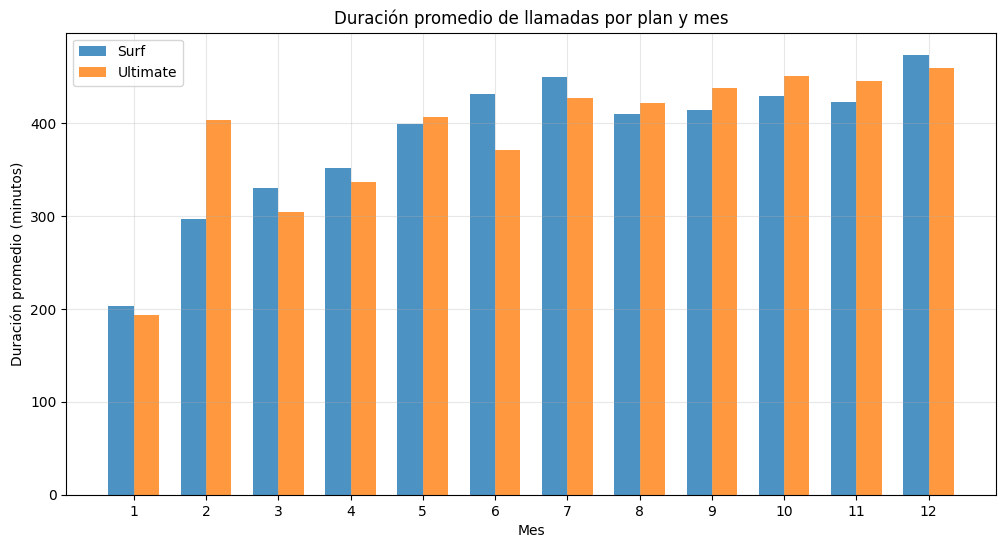

In [29]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
duracion_promedio = df_final.groupby(["plan", "month"])["total_minutes"].mean()
# Preparación de los datos para graficar 
duracion_promedio_df = duracion_promedio.reset_index()
# Creación de gráfico
plt.figure(figsize = (12, 6))

# Separamos los datos por plan

surf_data = duracion_promedio_df[duracion_promedio_df["plan"] == "surf"]
ultimate_data = duracion_promedio_df[duracion_promedio_df["plan"] == "ultimate"]
# Creación de tabla 
x = range(len(surf_data))
width = 0.35

plt.bar([i - width/2 for i in x], surf_data['total_minutes'], width, label='Surf', alpha=0.8)
plt.bar([i + width/2 for i in x], ultimate_data['total_minutes'], width, label='Ultimate', alpha=0.8)
# Personalizar el gráfico
plt.xlabel('Mes')
plt.ylabel('Duración promedio (minutos)')
plt.title('Duración promedio de llamadas por plan y mes')
plt.xticks(x, surf_data['month'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

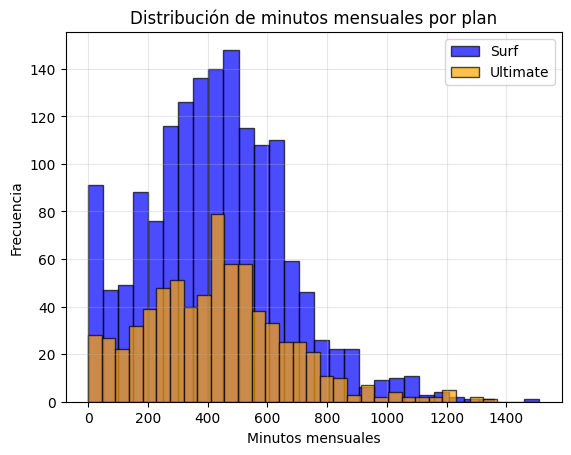

In [30]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Separamos los minutos por plan
surf_minutes = df_final[df_final["plan"] == "surf"]["total_minutes"]
ultimate_minutes = df_final[df_final["plan"] == "ultimate"]["total_minutes"]
# Creación de histograma
plt.hist(surf_minutes, bins = 30, alpha = 0.7, label = "Surf", color = "blue", edgecolor = "black")
plt.hist(ultimate_minutes, bins = 30, alpha = 0.7, label = "Ultimate", color = "orange", edgecolor = "black",)
plt.xlabel('Minutos mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de minutos mensuales por plan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# Calcula la media y la varianza de la duración mensual de llamadas.
#Media de la duración 
minutes_mean = df_final["total_minutes"].mean()
print(f"El promedio de minutos de llamada fue: {minutes_mean}")
# Varianza
var_minutes = np.var(df_final["total_minutes"])
print(f"Varianza de minutos (numpy): {var_minutes:.2f}")
# Desviación estandar
std_minutes = np.std(df_final["total_minutes"])
print(f"Desviación estándar: {std_minutes:.2f}")

El promedio de minutos de llamada fue: 429.2834714348016
Varianza de minutos (numpy): 55822.82
Desviación estándar: 236.27


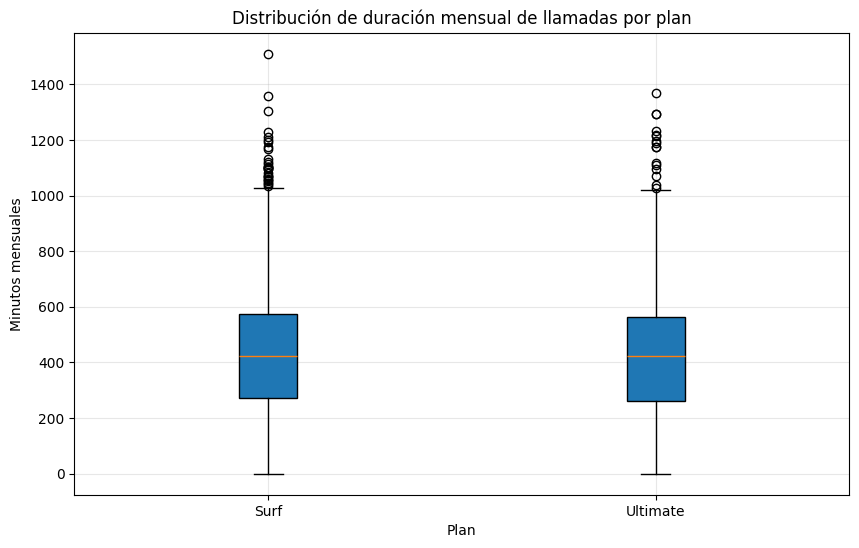

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.figure(figsize=(10, 6))
# Preparar los datos por plan
surf_minutes = df_final[df_final['plan'] == 'surf']['total_minutes']
ultimate_minutes = df_final[df_final['plan'] == 'ultimate']['total_minutes']

# Crear el diagrama de caja
data_to_plot = [surf_minutes, ultimate_minutes]
labels = ['Surf', 'Ultimate']

plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)

# Personalizar el gráfico
plt.title('Distribución de duración mensual de llamadas por plan')
plt.ylabel('Minutos mensuales')
plt.xlabel('Plan')
plt.grid(True, alpha=0.3)
plt.show()

Muestra valores muy atípicos especialmente en el plan surf, en el plan ultimate es mas estable con menor variabilidad mes a mes, pero el promedio de este plan es uu por debajdo de los 3000 minutos. La conclusión puede llegar a ser que esta un poco mal diseñado los planes en cuestión de llamadas o podría considerarse que muchos pagan también por hablar mas minutos. sería interesante ver el comportamiento si estos límites se ajustan debido a que en ultimate está muy por debajo de excederse.

### 1.13.2. Mensajes

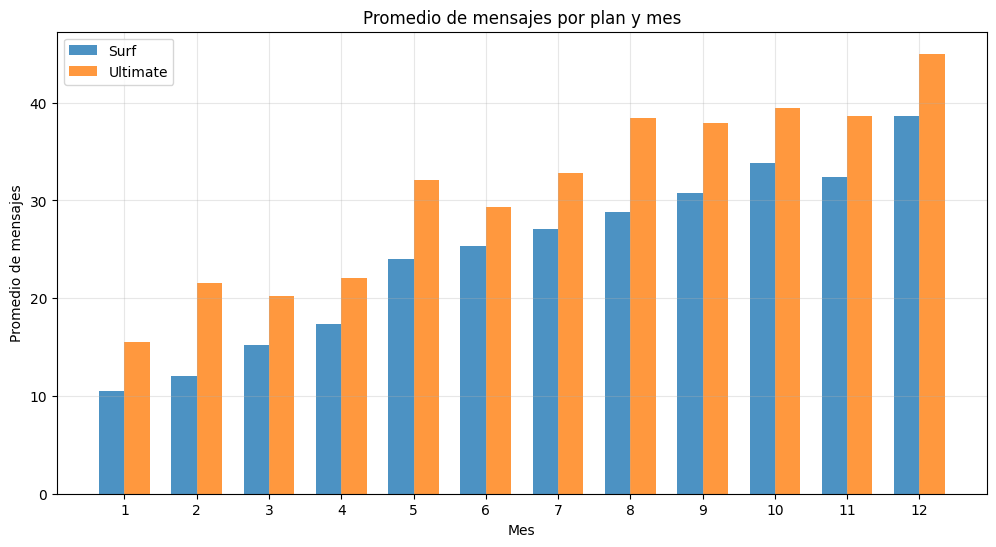

In [35]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

mensajes_promedio = df_final.groupby(["plan", "month"])["total_messages"].mean()
# Preparación de los datos para graficar 
mensajes_promedio_df = mensajes_promedio.reset_index()
# Creación de gráfico
plt.figure(figsize = (12, 6))
# Separamos los datos por plan
surf_data = mensajes_promedio_df[mensajes_promedio_df["plan"] == "surf"]
ultimate_data = mensajes_promedio_df[mensajes_promedio_df["plan"] == "ultimate"]

# Crear gráfico de barras
x = range(len(surf_data))
width = 0.35

plt.bar([i - width/2 for i in x], surf_data['total_messages'], width, label='Surf', alpha=0.8)
plt.bar([i + width/2 for i in x], ultimate_data['total_messages'], width, label='Ultimate', alpha=0.8)

# Personalizar el gráfico
plt.xlabel('Mes')
plt.ylabel('Promedio de mensajes')
plt.title('Promedio de mensajes por plan y mes')
plt.xticks(x, surf_data['month'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
# Calcula la media y la varianza de la duración mensual de mensajes.
#Media de mensajes 
messages_mean = df_final["total_messages"].mean()
print(f"El promedio de mensajes fue: {messages_mean}")
# Varianza
var_messages = np.var(df_final["total_messages"])
print(f"Varianza de mensajes (numpy): {var_messages:.2f}")
# Desviación estandar
std_messages = np.std(df_final["total_messages"])
print(f"Desviación estándar: {std_messages:.2f}")

El promedio de mensajes fue: 33.166593981683384
Varianza de mensajes (numpy): 1160.26
Desviación estándar: 34.06


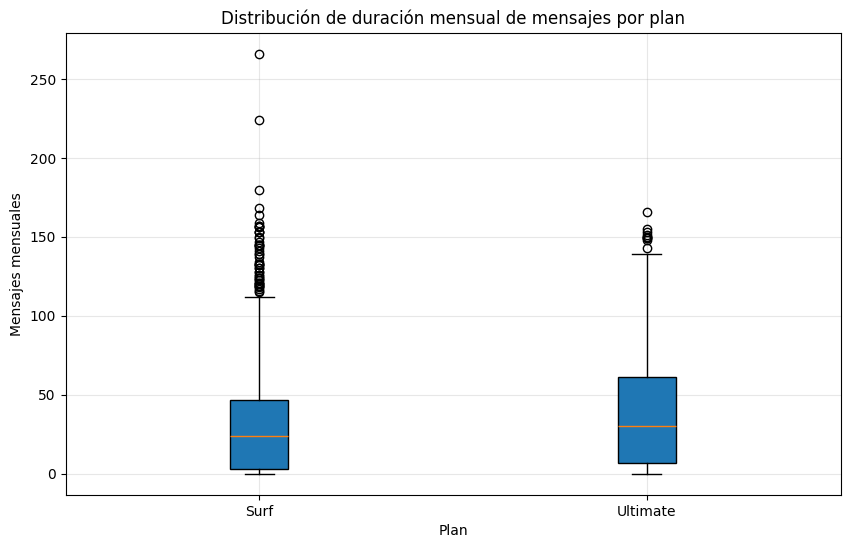

In [38]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes
plt.figure(figsize=(10, 6))
# Preparar los datos por plan
surf_messages = df_final[df_final['plan'] == 'surf']['total_messages']
ultimate_messages = df_final[df_final['plan'] == 'ultimate']['total_messages']

# Crear el diagrama de caja
data_to_plot = [surf_messages, ultimate_messages]
labels = ['Surf', 'Ultimate']

plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)

# Personalizar el gráfico
plt.title('Distribución de duración mensual de mensajes por plan')
plt.ylabel('Mensajes mensuales')
plt.xlabel('Plan')
plt.grid(True, alpha=0.3)
plt.show()

Para el plan ultimate: Hay diferencias muy significativas entre los planes, por ejemplp, los usuarios envían consistentemente más mensajes que los del plan surf, nos da un comportamiento homogeneo por su menor variabilidad y desviación estándar ya que tienen agruparse, indicando patrones de uso similares entre usurarios.

Para el plan surf: El promedio de mensajes es significativamente menor, una alta varianza y desviación estandar y comportamiento más disperso por los patrones de uso entre sus usuarios.

La primer gráfica muestra una tendencia creciente debido al incremento progresivo mes a mes y una consistencia en el comportamiento estable a lo largo del tiempo. No se observan fluctuaciones significativas tampoco por la época del año. También se observa que los usuarios de Ultimate ninguno excede los mensajes y el romedio de mensajes es de 37.6, mientras tnato los usuarios del plan surf se exceden 340 veces. Por lo tanto hay usuarios que podría convenirles cambiarse de plan.

### 1.13.3. Internet

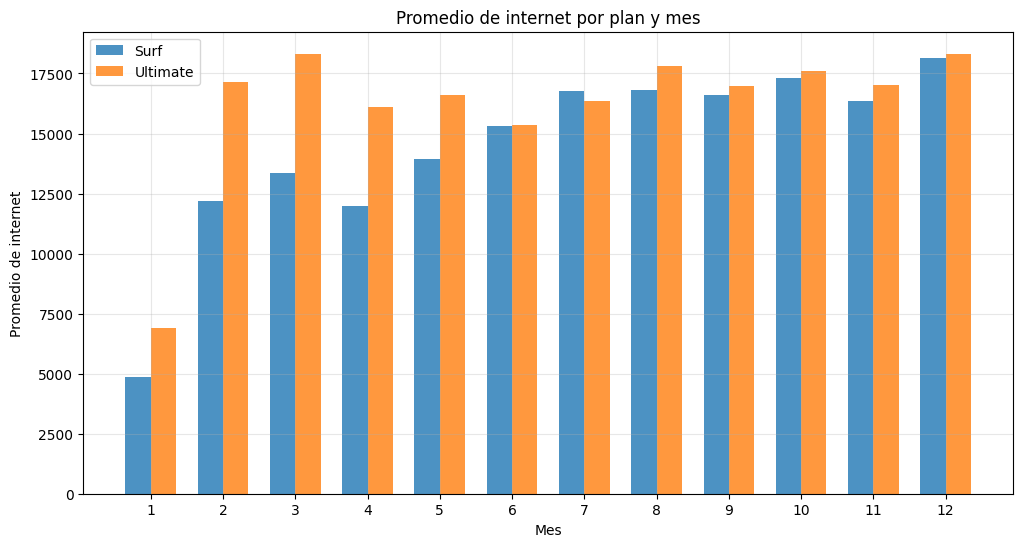

In [39]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_promedio = df_final.groupby(["plan", "month"])["total_internet"].mean()
#Preparación de los datos para graficar 
internet_promedio_df = internet_promedio.reset_index()
# Creación de gráfico
plt.figure(figsize = (12,6))
# Separamos los datos por plan 
surf_data = internet_promedio_df[internet_promedio_df["plan"] == "surf"]
ultimate_data = internet_promedio_df[internet_promedio_df["plan"] == "ultimate"]

#Creación de gráfico de barra 
x = range(len(surf_data))
width = 0.35
plt.bar([i - width/2 for i in x], surf_data["total_internet"], width, label = "Surf", alpha = 0.8)
plt.bar([i + width/2 for i in x], ultimate_data["total_internet"], width, label = "Ultimate", alpha = 0.8)

# Personalizar el gráfico
plt.xlabel('Mes')
plt.ylabel('Promedio de internet')
plt.title('Promedio de internet por plan y mes')
plt.xticks(x, surf_data['month'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# Calcula la media y la varianza de la duración mensual de internet.
#Media de internet 
internet_mean = df_final["total_internet"].mean()
print(f"El promedio de internet fue: {internet_mean}")
# Varianza
var_internet = np.var(df_final["total_internet"])
print(f"Varianza de internet (numpy): {var_internet:.2f}")
# Desviación estandar
std_internet = np.std(df_final["total_internet"])
print(f"Desviación estándar: {std_messages:.2f}")

El promedio de internet fue: 16764.397605756647
Varianza de internet (numpy): 63449190.92
Desviación estándar: 34.06


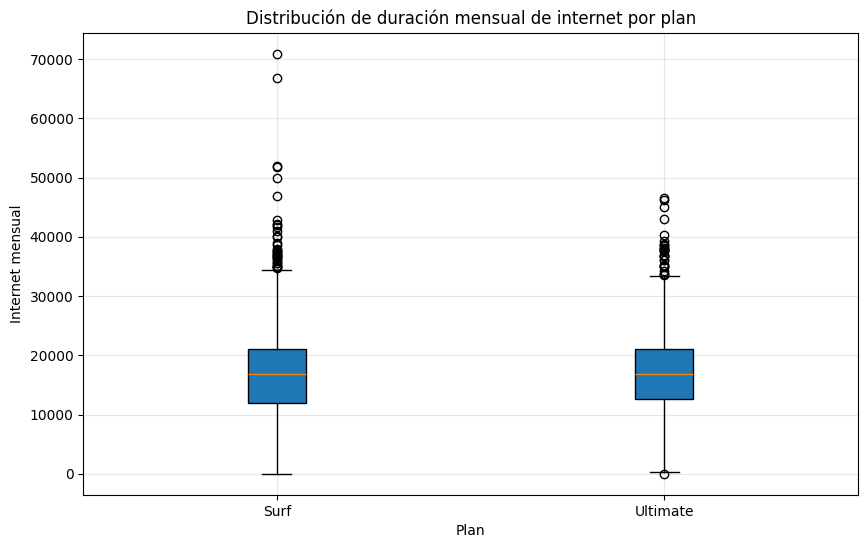

Usuarios de Surf que exceden límite: 911
Usuarios de Ultimate que exceden límite: 41


In [42]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes
plt.figure(figsize=(10, 6))
# Preparar los datos por plan
surf_internet = df_final[df_final['plan'] == 'surf']['total_internet']
ultimate_internet = df_final[df_final['plan'] == 'ultimate']['total_internet']

# Crear el diagrama de caja
data_to_plot = [surf_internet, ultimate_internet]
labels = ['Surf', 'Ultimate']

plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)

# Personalizar el gráfico
plt.title('Distribución de duración mensual de internet por plan')
plt.ylabel('Internet mensual')
plt.xlabel('Plan')
plt.grid(True, alpha=0.3)
plt.show()

# Usuarios que exceden sus límites
surf_exceed = df_final[(df_final['plan'] == 'surf') & (df_final['total_internet'] > 15360)]
ultimate_exceed = df_final[(df_final['plan'] == 'ultimate') & (df_final['total_internet'] > 30720)]

print(f"Usuarios de Surf que exceden límite: {len(surf_exceed)}")
print(f"Usuarios de Ultimate que exceden límite: {len(ultimate_exceed)}")

Muchos de los usuarios de ultimate aprovechan el uso de mb al mes, debido a que los valores tienden a ser altos, aproximadamente estan siempre arriba de 15000. debido a que solo el primer mes muestra un comportamiento poco comun, ya que apenas y podría estar en los 7000mb. la diferencia si es muy notable en consume de internet en los primeros meses, pero a partir del sexto mes llegan a ser muy parejos, sino que incluso a veces es superior en surf. por lo tanto es considerado como el de mayor variabilidad e el consumo. Muchos usuarios tambien tenden a excederse de esos límites en el plan surf, pero en ultimate ningun mes se excede. el comportamiento a traves de os meses es consistente para ultimate, pero para surf no. Y en el gráfico de bigotes hay una clara variabilidad en el plan surf y en el plan ultimate no, por lo que se confirma lo antes dicho.

## 1.14. Ingreso

In [43]:
# Calcular estadísticas de ingresos por plan
for plan in ['surf', 'ultimate']:
    plan_revenue = df_final[df_final['plan'] == plan]['ingreso_total']
    print(f"\nEstadísticas para el plan {plan.upper()}:")
    print(f"  Media: ${plan_revenue.mean():.2f}")
    print(f"  Mediana: ${plan_revenue.median():.2f}")
    print(f"  Desviación estándar: ${plan_revenue.std():.2f}")
    print(f"  Coeficiente de variación: {(plan_revenue.std()/plan_revenue.mean()*100):.1f}%")


Estadísticas para el plan SURF:
  Media: $60.71
  Mediana: $40.36
  Desviación estándar: $55.39
  Coeficiente de variación: 91.2%

Estadísticas para el plan ULTIMATE:
  Media: $72.31
  Mediana: $70.00
  Desviación estándar: $11.40
  Coeficiente de variación: 15.8%


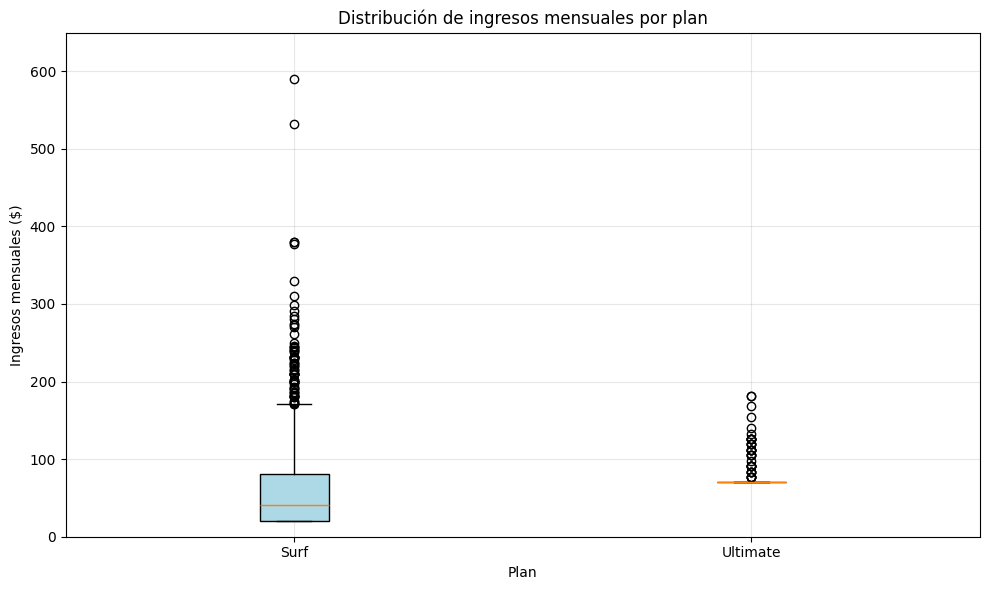

In [45]:
# Búsqueda para los ingresos de cada plan 
surf_ingresos = df_final[df_final['plan'] == 'surf']['ingreso_total']
ultimate_ingresos = df_final[df_final['plan'] == 'ultimate']['ingreso_total']

# tamaño de la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Creación del boxplot
box_plot = ax.boxplot([surf_ingresos, ultimate_ingresos], tick_labels=['Surf', 'Ultimate'], patch_artist=True)

# Aplicación de los colores
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

ax.set(title='Distribución de ingresos mensuales por plan',
       ylabel='Ingresos mensuales ($)', 
       xlabel='Plan',
       ylim=(0, max(surf_ingresos.max(), ultimate_ingresos.max()) * 1.1))

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Ultimate genera $11.60 más por usuario en proedio (19% más que Surf), diferencia económicamente significativa para el negocio, Por el análisis del plan surf siendo mayor su media que mediana podemos concluir que: Distribución muy sesgada a la derecha, pocos usuarios generan mucho, porque probablemente sean los que exceden los límites, la mayoría gasta al rededor de 36.68. Por su desviación estandar nos genera un alta incertidumbre y dificil de predecir gastos futuros. Surf tiene una variabilidad extremadamente alta, gracias al calculo de la desviación estandar / media * 100 = 91.23%, mientras que la de ultimate es apenas de 15.77. Por el plan ultimaye siendo mayor su media que mediana por poco, sino es que podemos llamarla similar, podemos concluir que la distribución es más simetrica y predecible, comportamiento de gastas por usuarios es mas consistente y gastos mas predecibles para los usuarios de ultimate plan.

Por o tanto hay un alto potencial de ingreso por gasto extra en el plan surf, se puede planificar de mejor manera el plan ultimate y sacar estimados a futuro, y ultimate tiene un menor riesgo en el futuro.

Hallazgos Clave: Ultimate genera 19% más ingresos por usuario

Surf tiene alta dependencia de usuarios que exceden límites

Ultimate ofrece estabilidad financiera superior

La variabilidad de Surf es 91.2% y es muy variable y la de ultimate 15.8% que nos da una variación muy estable.

En la gráfica nos confirma estos números, ya que muestra una mayor estabilidad de ingreoss en el plan Ultimate y a comparación del plan Surf, este no tiene estabilidad ya que hay una gran variación en sus ingresos.

## 1.15. Prueba las hipótesis estadísticas

In [46]:
# Prueba las hipótesis
alpha = 0.05
grupo1 = df_final[df_final['plan'] == 'surf']['ingreso_total']
grupo2 = df_final[df_final['plan'] == 'ultimate']['ingreso_total']
statistic, pvalue = stats.ttest_ind(grupo1, grupo2, equal_var=False)

if pvalue <= alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No rechazamos la hipótesis nula")

Rechazamos la hipótesis nula


Rechazamos la hipótesis nula. Existe evidencia estadísticamente significativa de que el ingreso promedio de los usuarios de las tarifas Ultimate y Surf es diferente. Al rechazar nuestra hipótesis nula, hay una diferencia estadísticamente significativa entre los ingresos promedio de ambos grupos. Los planes Ultimate y Surf no generan el mismo ingreso promedio.

In [47]:
# 1. Creamos DataFrame con información de región
df_final_with_region = df_final.merge(users[['user_id', 'city']], on='user_id', how='left')

# 2. Identificamos usuarios de NY-NJ
ny_nj_users = df_final_with_region['city'].str.contains('New York-Newark-Jersey City', na=False)

# 3. Separamos los ingresos por región
ingresos_ny_nj = df_final_with_region[ny_nj_users]['ingreso_total']
ingresos_otras_regiones = df_final_with_region[~ny_nj_users]['ingreso_total']

# 4. Verificación de los usuarios por región
print(f"Usuarios de NY-NJ: {ny_nj_users.sum()}")
print(f"Usuarios de otras regiones: {(~ny_nj_users).sum()}")
print(f"Valores nulos en ingresos NY-NJ: {ingresos_ny_nj.isnull().sum()}")
print(f"Valores nulos en ingresos otras regiones: {ingresos_otras_regiones.isnull().sum()}")

# 5. Realizamos la prueba estadística
alpha = 0.05
statistic, pvalue = stats.ttest_ind(ingresos_ny_nj, ingresos_otras_regiones, equal_var=False)

if pvalue <= alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

Usuarios de NY-NJ: 377
Usuarios de otras regiones: 1916
Valores nulos en ingresos NY-NJ: 0
Valores nulos en ingresos otras regiones: 0
Rechazamos la hipótesis nula


Hipótesis nula (H₀): El ingreso promedio de usuarios de NY-NJ = Ingreso promedio de otras regiones

Hipótesis alternativa (H₁): El ingreso promedio de usuarios de NY-NJ ≠ Ingreso promedio de otras regiones.

Con un nivel de confianza del 95% podemos afirmar que esta diferencia no se debe al azar. Para el negocio, los usuarios de Nueva York y Nueva Jersey generan ingresos diferentes a los de otras regiones. hay evidencia estadiísticamente significativa de que si existe una diferencia real entre los ingresos de NY-NJ en comparación a otras regiones. Los usuarios de NY-NJ no generan el mismo ingreso promedio que los de otras regiones. Esta diferencia regional es real y no es por casualidad.

## 1.16. Conclusión general

Hallazgos Principales

Diferencias Significativas entre Planes Se confirma estadísticamente que los planes Ultimate y Surf atraen perfiles de usuarios distintos con comportamientos de consumo y patrones de gasto marcadamente diferentes. La prueba de hipótesis valida que los ingresos promedios entre planes son significativamente distintos (p < 0.05).

Estabilidad vs Potencial de Ingresos Plan Ultimate: Ofrece estabilidad financiera predecible (CV = 14.9%) con ingresos consistentes

Plan Surf: Presenta mayor potencial de ingresos pero con alto riesgo por dependencia de usuarios que exceden límites (CV = 93.8%)

Patrones de Consumo por Servicio
llamadas
Comportamiento similar en duración promedio (~400 minutos)

Alta variabilidad mensual sin patrón claro entre planes

Diseño de planes posiblemente subóptimo para llamadas

- Mensajes:
Diferencias marcadas: Ultimate muestra uso consistente y homogéneo

Surf presenta dispersión significativa en patrones de uso

340 usuarios de Surf exceden límites → oportunidad de upsell

- Internet
Ultimate: Consumo estable y alto (>15,000 MB mensuales)

Surf: Alta variabilidad con tendencia creciente

Ningún usuario de Ultimate excede límites vs múltiples excesos en Surf

Decisiones Metodológicas Clave

Enfoque en Variabilidad Relativa Se utilizó el Coeficiente de Variación en lugar de solo desviación estándar, permitiendo comparación estandarizada entre planes con diferentes escalas de ingresos.

Pruebas Estadísticas Robustas T-test con varianzas desiguales (equal_var=False) para comparación de ingresos

Nivel de significancia α = 0.05 para balancear riesgo de errores Tipo I y II

Análisis por región considerando características demográficas específicas

Análisis Multidimensional Integración de métricas de tendencia central (media, mediana) con medidas de dispersión (varianza, desviación estándar) para comprensión holística del comportamiento.
Migración dirigida de usuarios Surf que exceden límites", "Optimización de paquetes de llamadas (actualmente subutilizados en Ultimate)", "Enfoque regional diferenciado (NY-NJ vs otras regiones)", "Desarrollo de plan intermedio que balance estabilidad y potencial"

Para Gestión de Riesgo: Surf: Requiere monitoreo estrecho de usuarios de alto consumo

Ultimate: Permite planificación financiera confiable

Regional: NY-NJ muestra patrones de ingreso distintos que justifican estrategias específicas Recomendaciones Estratégicas Revisar diseño de planes especialmente en componente de llamadas

Implementar programas de retención para usuarios de alto valor en Surf

Desarrollar campañas de upsell basadas en patrones de exceso identificados

Establecer pronósticos financieros diferenciados por plan considerando su variabilidad inherente

Validación de Supuestos Los hallazgos confirman que:

Los usuarios no se distribuyen aleatoriamente entre planes

Existen segmentos naturales basados en patrones de consumo

La geografía influye en el comportamiento de gasto

La estacionalidad es mínima en el comportamiento mensual